<a href="https://colab.research.google.com/github/kangdoung/CS114.K21/blob/master/Do_an_cuoi_ky/Classify_face_celeb_svc_and_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bài toán nhận dạng người nổi tiếng**
* Input: ảnh của 1 trong 5 người  
* Output: tên người nổi tiếng của ảnh đó  
* Dataset gồm ảnh của 5 người: Amee, My Tam,Son Tung MTP, Jack và NDLN.  
Dữ liệu được thu thập từ google image sau đó được cắt và lấy khuôn mặt của mỗi người trên. Thu thập 100 tấm ảnh của mỗi người.  
Dataset được lưu trên google drive ( [*link*](/https://drive.google.com/drive/folders/1YjNGdPb_3equCM7M4tBaXYQpUN8AFIMd?usp=sharing)).


In [ ]:
import numpy as np
import pandas as pd
import cv2 #open cv
import os
import matplotlib.pyplot as plt

# Load dữ liệu và gán label cho dữ liệu

## Tập TRAIN


In [184]:
# building an array of images and finding its shape.
Images_train = []
for imgfolder in os.listdir('drive/My Drive/Data_No_Aug/ML/Train/'):
    i = 1
    for filename in os.listdir('drive/My Drive/Data_No_Aug/ML/Train/' + imgfolder):
        filename = 'drive/My Drive/Data_No_Aug/ML/Train/' + imgfolder + '/' + filename
        print(i)
        i+=1
        print(filename)
        img = cv2.imread(filename,0)
        #print(img.shape)
        img = cv2.resize(img, (200,200), interpolation = cv2.INTER_AREA)
        Images_train.append(img)

Images_train = np.asarray(Images_train)
Images_train.shape

1
drive/My Drive/Data_No_Aug/ML/Train/TranThanh/TranThanh23.jpg
2
drive/My Drive/Data_No_Aug/ML/Train/TranThanh/TranThanh24.jpg
3
drive/My Drive/Data_No_Aug/ML/Train/TranThanh/TranThanh21.jpg
4
drive/My Drive/Data_No_Aug/ML/Train/TranThanh/TranThanh22.jpg
5
drive/My Drive/Data_No_Aug/ML/Train/TranThanh/TranThanh25.jpg
6
drive/My Drive/Data_No_Aug/ML/Train/TranThanh/TranThanh30.jpg
7
drive/My Drive/Data_No_Aug/ML/Train/TranThanh/TranThanh32.jpg
8
drive/My Drive/Data_No_Aug/ML/Train/TranThanh/TranThanh36.jpg
9
drive/My Drive/Data_No_Aug/ML/Train/TranThanh/TranThanh31.jpg
10
drive/My Drive/Data_No_Aug/ML/Train/TranThanh/TranThanh29.jpg
11
drive/My Drive/Data_No_Aug/ML/Train/TranThanh/TranThanh34.jpg
12
drive/My Drive/Data_No_Aug/ML/Train/TranThanh/TranThanh37.jpg
13
drive/My Drive/Data_No_Aug/ML/Train/TranThanh/TranThanh38.jpg
14
drive/My Drive/Data_No_Aug/ML/Train/TranThanh/TranThanh33.jpg
15
drive/My Drive/Data_No_Aug/ML/Train/TranThanh/TranThanh27.jpg
16
drive/My Drive/Data_No_Aug/ML/T

(400, 200, 200)

cv2.imread(filename, 0) :

0 = cv2.IMREAD_GRAYSCALE  
tương tụ 1 cho IMREAD_COLOR và -1 cho IMREAD_UNCHANGED

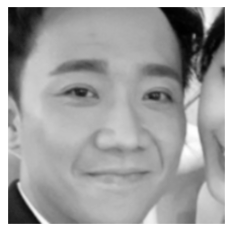

In [170]:
plt.imshow(Images_train[10], cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([]) 
plt.show()

In [185]:
label_train = []
for imgfolder in os.listdir('drive/My Drive/Data_No_Aug/ML/Train/'):
    for filename in os.listdir('drive/My Drive/Data_No_Aug/ML/Train/' + imgfolder):
        label_train.append(imgfolder)
label_train = np.asarray(label_train)
label_train.shape

(400,)

## Tập TEST

In [186]:
# building an array of images and finding its shape.
Images_test = []
for imgfolder in os.listdir('drive/My Drive/Data_No_Aug/ML/Test/'):
    i = 1
    for filename in os.listdir('drive/My Drive/Data_No_Aug/ML/Test/' + imgfolder):
        filename = 'drive/My Drive/Data_No_Aug/ML/Test/' + imgfolder + '/' + filename
        print(i)
        i += 1
        print(filename)
        img = cv2.imread(filename,0)
        img = cv2.resize(img, (200,200), interpolation = cv2.INTER_AREA)
        print(img.shape)
        Images_test.append(img)
Images_test = np.asarray(Images_test)
Images_test.shape

1
drive/My Drive/Data_No_Aug/ML/Test/TranThanh/TranThanh4.jpg
(200, 200)
2
drive/My Drive/Data_No_Aug/ML/Test/TranThanh/TranThanh1.jpg
(200, 200)
3
drive/My Drive/Data_No_Aug/ML/Test/TranThanh/TranThanh2.jpg
(200, 200)
4
drive/My Drive/Data_No_Aug/ML/Test/TranThanh/TranThanh5.jpg
(200, 200)
5
drive/My Drive/Data_No_Aug/ML/Test/TranThanh/TranThanh3.jpg
(200, 200)
6
drive/My Drive/Data_No_Aug/ML/Test/TranThanh/TranThanh13.jpg
(200, 200)
7
drive/My Drive/Data_No_Aug/ML/Test/TranThanh/TranThanh15.jpg
(200, 200)
8
drive/My Drive/Data_No_Aug/ML/Test/TranThanh/TranThanh17.jpg
(200, 200)
9
drive/My Drive/Data_No_Aug/ML/Test/TranThanh/TranThanh9.jpg
(200, 200)
10
drive/My Drive/Data_No_Aug/ML/Test/TranThanh/TranThanh7.jpg
(200, 200)
11
drive/My Drive/Data_No_Aug/ML/Test/TranThanh/TranThanh14.jpg
(200, 200)
12
drive/My Drive/Data_No_Aug/ML/Test/TranThanh/TranThanh18.jpg
(200, 200)
13
drive/My Drive/Data_No_Aug/ML/Test/TranThanh/TranThanh20.jpg
(200, 200)
14
drive/My Drive/Data_No_Aug/ML/Test/Tra

(102, 200, 200)

In [187]:
label_test = []
for imgfolder in os.listdir('drive/My Drive/Data_No_Aug/ML/Test/'):
    for filename in os.listdir('drive/My Drive/Data_No_Aug/ML/Test/' + imgfolder):
        label_test.append(imgfolder)
label_test = np.asarray(label_test)
label_test.shape

(102,)

### Khác

In [356]:
x_train = Images_train
x_test = Images_test
y_train = label_train
y_test = label_test

## Model


In [121]:
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

Thêm các thư viện cần thiết

In [193]:
pca = RandomizedPCA(n_components = 150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight = 'balanced')
model = make_pipeline(pca, svc)

In [380]:
# fit model
#pca = RandomizedPCA(n_components = 150, whiten=True, random_state=42)
model = SVC(kernel='linear', probability=True)
#model = make_pipeline(pca, svc)
model.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [358]:
#flatten images.
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

In [125]:
from sklearn.model_selection import learning_curve, GridSearchCV

In [195]:
# doing cross validation to tune the params of SVC

param_grid = {'svc__C': [1, 5, 10, 50, 100, 500],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(x_train, y_train)
print(grid.best_params_)

KeyboardInterrupt: ignored

In [180]:
grid.best_score_

0.6074999999999999

In [381]:
pred = model.predict(x_test)

In [132]:
from sklearn.metrics import  accuracy_score
from sklearn.metrics import classification_report

In [382]:
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

        Amee       0.55      0.60      0.57        20
         MTP       0.65      0.68      0.67        19
       MyTam       0.55      0.61      0.58        18
        NDLN       0.65      0.57      0.60        23
   TranThanh       0.55      0.50      0.52        22

    accuracy                           0.59       102
   macro avg       0.59      0.59      0.59       102
weighted avg       0.59      0.59      0.59       102



In [383]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(pred, y_test))

[[12  1  1  2  4]
 [ 1 13  2  1  2]
 [ 1  3 11  1  2]
 [ 5  1  3 13  1]
 [ 3  2  3  3 11]]


In [384]:
accuracy_score(pred, y_test)

0.5882352941176471

In [167]:
test = model.predict(x_train)

In [ ]:
confusion_matrix(test, y_train)

array([[80,  0,  0,  0,  0],
       [ 0, 80,  0,  0,  0],
       [ 0,  0, 80,  0,  0],
       [ 0,  0,  0, 80,  0],
       [ 0,  0,  0,  0, 80]])

In [168]:
accuracy_score(test, y_train)

0.94

### Nhận xét:
Overfiting

model cho kết quả dự đoán khá thấp do chỉ sử dụng PCA để trích chọn đặc trưng.

### Logistic Regression


# Thử nghiệm bộ dữ liệu với CNN



In [2]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.optimizers import SGD
import keras
from keras.utils import np_utils
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os

Using TensorFlow backend.


In [284]:
image_size = 50
def read_date(path):
  img = []
  label = []
  folders = os.listdir(path)
  for folder in os.listdir(path):
    i = 1
    for files in os.listdir(path+'/'+folder):
      files_name = path + '/'+folder+'/' + files
      
      print(files_name)
      print('STT: {}'.format(i))
      i += 1
      image = cv2.imread(files_name,0)
      
      image = cv2.resize(image, (image_size, image_size))
      images=np.reshape(image, image_size*image_size)
      img.append(images)
      label.append(folder)

  return np.asarray(img),np.asarray(label)

train_path = 'drive/My Drive/data_cnn/Train'
x_train, y_train = read_date(train_path)

test_path = 'drive/My Drive/data_cnn/Test'
x_test, y_test = read_date(test_path)

val_path = 'drive/My Drive/data_cnn/Val'
x_val, y_val = read_date(val_path)

Streaming output truncated to the last 5000 lines.
STT: 285
drive/My Drive/data_cnn/Train/MyTam/MyTam25__blur2.0.jpg
STT: 286
drive/My Drive/data_cnn/Train/MyTam/MyTam24__blur2.0.jpg
STT: 287
drive/My Drive/data_cnn/Train/MyTam/MyTam16__blur2.0.jpg
STT: 288
drive/My Drive/data_cnn/Train/MyTam/MyTam23__blur1.0.jpg
STT: 289
drive/My Drive/data_cnn/Train/MyTam/MyTam18__blur4.0.jpg
STT: 290
drive/My Drive/data_cnn/Train/MyTam/MyTam25__blur1.0.jpg
STT: 291
drive/My Drive/data_cnn/Train/MyTam/MyTam74__blur4.0.jpg
STT: 292
drive/My Drive/data_cnn/Train/MyTam/MyTam68__blur2.0.jpg
STT: 293
drive/My Drive/data_cnn/Train/MyTam/MyTam33__blur4.0.jpg
STT: 294
drive/My Drive/data_cnn/Train/MyTam/MyTam49__blur1.0.jpg
STT: 295
drive/My Drive/data_cnn/Train/MyTam/MyTam59__blur2.0.jpg
STT: 296
drive/My Drive/data_cnn/Train/MyTam/MyTam53__blur2.0.jpg
STT: 297
drive/My Drive/data_cnn/Train/MyTam/MyTam35__blur4.0.jpg
STT: 298
drive/My Drive/data_cnn/Train/MyTam/MyTam62__blur2.0.jpg
STT: 299
drive/My Drive/d

In [273]:
x_train.shape

(3370, 10000)

In [6]:
y_train.shape

(3370,)

In [7]:
x_test.shape

(720, 2500)

In [8]:
y_test.shape

(720,)

In [9]:
x_val.shape

(720, 2500)

In [ ]:
print(y_val)

## Chỉnh sửa các biến đầu vào đề phù hợp với yêu cầu đầu vào của cnn

In [285]:
from sklearn.preprocessing import LabelEncoder
labelencoder_X=LabelEncoder()
y_train = labelencoder_X.fit_transform(y_train)
y_test = labelencoder_X.transform(y_test)
y_val = labelencoder_X.transform(y_val)


In [286]:
x_train = x_train.reshape(x_train.shape[0], 50, 50, 1)
x_val = x_val.reshape(x_val.shape[0], 50, 50, 1)
x_test = x_test.reshape(x_test.shape[0], 50, 50, 1)

In [287]:
y_train = np_utils.to_categorical(y_train, 5)
y_val = np_utils.to_categorical(y_val, 5)
y_test = np_utils.to_categorical(y_test, 5)
print('Dữ liệu y ban đầu ', y_train[0])
print('Dữ liệu y sau one-hot encoding ',y_train[0])

Dữ liệu y ban đầu  [0. 0. 0. 1. 0.]
Dữ liệu y sau one-hot encoding  [0. 0. 0. 1. 0.]


## Xây dựng model

In [288]:
num_classes = 5
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape = (50,50,1), activation = 'relu'))
model.add(BatchNormalization(axis = -1))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(units = 1024, activation = 'relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.5))
model.add(Dense(units = num_classes, activation = 'softmax'))

In [ ]:
#opt = keras.optimizers.Adam(learning_rate=0.0005)

In [289]:
model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])
H = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          batch_size=328, epochs=100, verbose=1)

Train on 3370 samples, validate on 720 samples
Epoch 1/100
3370/3370 [==============================] - 2s 468us/step - loss: 2.1046 - accuracy: 0.3935 - val_loss: 9.4095 - val_accuracy: 0.2028
Epoch 2/100
3370/3370 [==============================] - 1s 231us/step - loss: 1.3144 - accuracy: 0.5822 - val_loss: 5.0571 - val_accuracy: 0.2569
Epoch 3/100
3370/3370 [==============================] - 1s 230us/step - loss: 1.0187 - accuracy: 0.6528 - val_loss: 4.4093 - val_accuracy: 0.2069
Epoch 4/100
3370/3370 [==============================] - 1s 236us/step - loss: 0.8288 - accuracy: 0.7095 - val_loss: 3.3597 - val_accuracy: 0.3306
Epoch 5/100
3370/3370 [==============================] - 1s 234us/step - loss: 0.6975 - accuracy: 0.7629 - val_loss: 3.3503 - val_accuracy: 0.2292
Epoch 6/100
3370/3370 [==============================] - 1s 234us/step - loss: 0.5992 - accuracy: 0.7932 - val_loss: 2.4305 - val_accuracy: 0.3389
Epoch 7/100
3370/3370 [==============================] - 1s 235us/step 

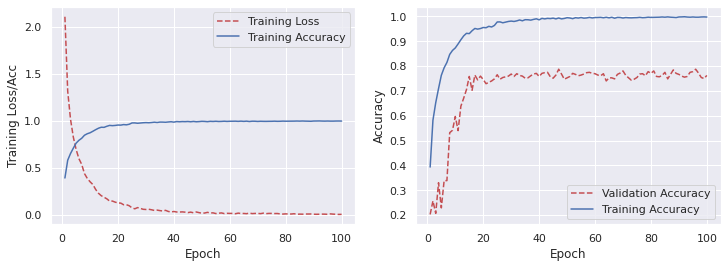

In [290]:
# Get training and test loss histories
training_loss = H.history['loss']
training_acc = H.history['accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

fig=plt.figure(figsize=(12, 4))
# Visualize loss history
fig.add_subplot(121)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, training_acc, 'b-')
plt.legend(['Training Loss', 'Training Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Training Loss/Acc')

# Get training and test loss histories
val_acc = H.history['val_accuracy']
training_acc = H.history['accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(val_acc) + 1)

# Visualize loss history
fig.add_subplot(122)
plt.plot(epoch_count, val_acc, 'r--')
plt.plot(epoch_count, training_acc, 'b-')
plt.legend(['Validation Accuracy', 'Training Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show();

In [291]:
# 9. Đánh giá model với dữ liệu test set
score = model.evaluate(x_test, y_test)
print(score)

720/720 [==============================] - 0s 175us/step
[1.7988516065809461, 0.6513888835906982]


In [292]:
model.save('drive/My Drive/data_cnn/model_at_12_12am')

### Dự đoán ảnh

In [297]:
from google.colab.patches import cv2_imshow

In [352]:
from google.colab import files
uploaded = files.upload()

Saving M63.jpg to M63.jpg


In [353]:
img = cv2.imread('M63.jpg', 0)
img_show = cv2.imread('M63.jpg', 0)

In [303]:
model = keras.models.load_model('drive/My Drive/data_cnn/model_at_12_12am')

In [354]:
img = cv2.resize(img, (50,50), interpolation = cv2.INTER_AREA)
img_pre = []
img_pre.append(img)
img_pre = np.asarray(img_pre)
img_pre = img_pre.reshape(img_pre.shape[0], 50, 50, 1)

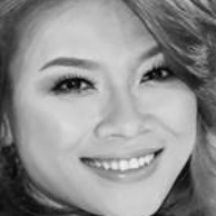

Dự đoán là: Ninh Dương Lan Ngọc


In [355]:
cv2_imshow(img_show)
if (model.predict_classes(img_pre) == 0):
  print("Dự đoán là: Amee")
elif (model.predict_classes(img_pre) == 1):
  print("Dự đoán là: MTP")
elif (model.predict_classes(img_pre) == 3):
  print("Dự đoán là: Ninh Dương Lan Ngọc")
elif (model.predict_classes(img_pre) == 2):
  print("Dự đoán là: Mỹ Tâm")
else:
  print("Dự đoán là: Trấn Thành")